# __SimpleNN__ (tensorflow)

механізми бібліотеки tensorflow.
- https://www.tensorflow.org/

In [253]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [254]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(42)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

In [255]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

x = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = x * TRUE_W + TRUE_B + noise * 10

In [256]:
noise

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([ 8.42245817e-02, -8.60903740e-01,  3.78123045e-01, -5.19627379e-03,
       -4.94531959e-01,  6.17819190e-01, -3.30820471e-01, -1.38408062e-03,
       -4.23734099e-01, -1.38720870e+00, -1.54881907e+00, -5.31983912e-01,
       -4.47564334e-01, -2.01158142e+00, -5.79260111e-01,  5.79389274e-01,
        1.30419672e+00,  6.77202582e-01, -7.45876133e-01,  1.03789639e+00,
        1.38204789e+00,  1.43191707e+00, -3.76431167e-01,  9.81584728e-01,
       -2.35978618e-01, -3.37632596e-01, -8.95932496e-01,  4.27540720e-01,
       -3.81055176e-01,  4.70069915e-01,  3.54137793e-02, -2.92727590e+00,
       -9.67070043e-01, -4.14027095e-01, -4.01375860e-01,  6.23287678e-01,
       -9.36488628e-01,  9.54493880e-01,  4.90253896e-01, -9.98048425e-01,
       -1.16864061e+00, -6.78972900e-01,  1.73310387e+00,  7.86430180e-01,
        9.22370180e-02,  2.27117896e-01, -9.18961167e-02,  1.12249768e+00,
       -9.17323411e-01,  8.05410087e-01,  1.1766098

### __`MODEL`__

- https://www.tensorflow.org/guide/intro_to_graphs
- https://www.tensorflow.org/guide/intro_to_modules

У нейронних мережах часто використовується активаційна функція ReLU:<br>
- `f(x) = max(x, 0)`

In [257]:
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor


@tf.function
def relu_activation(x: EagerTensor) -> EagerTensor:  # not Union[int, tf.Tensor] be cause @tf.function
    if tf.greater(x, 0):  # <tf.Tensor: shape=(), dtype=bool, numpy=True>
        return x
    
    return 0


print(relu_activation(tf.constant(1)).numpy())
print(relu_activation(tf.constant(-1)).numpy())

1
0


__Автоматичне диференціювання__
- https://www.tensorflow.org/guide/intro_to_graphs
<br>
За допомогою класу `GradientTape` - `tensorflow` записує всі операції,<br>
необхідні для обчислення похідної в змінну `tape` . Для того, щоб обчислити<br>
значення похідної в __конкретній точці__, потрібно викликати метод `gradient`.<br>
`x`- другий аргумент після функції - аргумент, за яким обчислюється похідна (причому це може бути тензор).

In [258]:
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor


def f(x: EagerTensor) -> EagerTensor:
    return 1 / x ** 2


x1 = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y1 = f(x1)
    dydx: EagerTensor = tape.gradient(y1, x1)
    print(dydx)  # tf.Tensor(-0.25, shape=(), dtype=float32)

tf.Tensor(-0.25, shape=(), dtype=float32)


Для того, щоб створити шар нейромережі, достатньо написати клас, який успадковується від `tf.Module`.<br>
Обов'язковою є реалізація магічного методу `__call__`, оскільки всі фактичні обчислення відбуваються саме там.

In [259]:
from typing import Optional, Union

import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor


class SimpleModule(tf.Module):
    def __init__(self, name: Optional[str]=None) -> None:
        super().__init__(name=name)
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(5.0)

    def __call__(self, x: EagerTensor) -> EagerTensor:
        return self.w * x + self.b


simple_module = SimpleModule(name='simple')
simple_module(tf.constant(5.0))

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [260]:
class DenseLayer(tf.Module):
    def __init__(self, in_features: int, out_features: int, name: Optional[str]=None):
        super().__init__(name=name)
        self.w = tf.Variable(
                             tf.random.normal([in_features, out_features]), name='w'
                             )
        self.b = tf.Variable(tf.zeros([out_features]), name='b')

    def __call__(self, x: EagerTensor):
        y: tf.Tensor = tf.matmul(x, self.w) + self.b

        return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None) -> EagerTensor:
    super().__init__(name=name)
    self.layer_1 = DenseLayer(in_features=3, out_features=3)
    self.layer_2 = DenseLayer(in_features=3, out_features=1)

  def __call__(self, x):
    x: tf.Tensor = self.layer_1(x)

    return self.layer_2(x)


nn = NN(name='neural_network')
print('Results:', nn(tf.constant([[2.0, 2.0, 2.0]])))  # start w from random

Results: tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


#### __`Training`__

- https://www.tensorflow.org/guide/basic_training_loops

визначимо дві функції: `loss` та `train`. Одна буде __обчислювати помилку__, а друга - __підлаштовувати ваги__.<br>

In [261]:
def loss(target_y: EagerTensor, predicted_y: EagerTensor) -> EagerTensor:
    return tf.reduce_mean(tf.square(target_y - predicted_y))


def train(model: SimpleModule, x: EagerTensor, y: EagerTensor, learning_rate: float) -> None:
    """Лише одна ітерація навчання."""
    with tf.GradientTape() as t:
        current_loss: tf.Tensor = loss(y, model(x))
        # механізми tensorflow для автоматичного диференціювання:
        dw, db = t.gradient(current_loss, [model.w, model.b])
        model.w.assign_sub(learning_rate * dw)  # метод assign_sub веде себе як оператор -=
        model.b.assign_sub(learning_rate * db)

In [262]:
def training_loop(model, x: EagerTensor, y: EagerTensor) -> None:
    for epoch in range(22):
        train(model, x, y, learning_rate=0.1)
        current_loss: EagerTensor = loss(y, model(x))
        print(f'loss: {current_loss}')

In [263]:
linear_model = SimpleModule()
training_loop(linear_model, x, y)

loss: 108.90384674072266
loss: 104.99842071533203
loss: 102.4900894165039
loss: 100.87901306152344
loss: 99.84420776367188
loss: 99.17951202392578
loss: 98.75257110595703
loss: 98.47830200195312
loss: 98.30211639404297
loss: 98.18893432617188
loss: 98.1162338256836
loss: 98.06952667236328
loss: 98.03950500488281
loss: 98.02023315429688
loss: 98.0078353881836
loss: 97.99988555908203
loss: 97.99476623535156
loss: 97.9914779663086
loss: 97.9893569946289
loss: 97.9880142211914
loss: 97.98713684082031
loss: 97.98657989501953


In [264]:
linear_model.name, linear_model.b.numpy(), linear_model.w.numpy()

('simple_module', 1.6132723, 2.6781948)

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD
- https://www.tensorflow.org/api_docs/python/tf/GradientTape

In [265]:
TRUE_W = [3.0, 2.0, 1.0]
TRUE_B = 2.0

NUM_EXAMPLES = 1000

x = tf.random.normal(shape=[NUM_EXAMPLES, 3])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = tf.reduce_sum(x * TRUE_W + TRUE_B, axis=1) + noise

In [266]:
neural_network = NN(name='neural_network_1')

In [267]:
# Функція навчання нейромережі
def train_NN(nn, input_x, output_y, learning_rate):
    # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск:
    optimizer = tf.optimizers.legacy.SGD(learning_rate)  # .Adam

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = nn(input_x)  #  neural_net(input_x)
        loss1 = loss(pred, output_y)  # cross_entropy(pred, output_y)

        # Створимо список параметрів, що оптимізуються
        params = [nn.layer_1.trainable_variables, nn.layer_2.trainable_variables]

        # Обчислимо за ними значення градієнта
        grads = g.gradient(loss1, params)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(grads[0], nn.layer_1.trainable_variables))
        optimizer.apply_gradients(zip(grads[1], nn.layer_2.trainable_variables))

In [268]:
# Перемішаємо тренувальні дані (split to batches & ...)
train_data = tf.data.Dataset.from_tensor_slices((x, y))
train_data = train_data.repeat().shuffle(256).batch(128).prefetch(1)
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [269]:
# Тренування мережі
loss_history = []  # кожні display_step кроків зберігатимемо в цьому списку поточну помилку нейромережі

# При тренуванні у циклі
# з тренувального датасету train_data виймаємо (метод take для тренувального датасету) випадкову підмножину для тренування
for step, (batch_x, batch_y) in enumerate(train_data.take(256)):  # train_data.take(batch_size)
    # оновлюємо ваги нейромережі
    train_NN(neural_network, batch_x, batch_y, learning_rate=0.1)
    pred = neural_network(batch_x)
    current_loss = loss(pred, batch_y)
    
    if step % 1 == 0:
        loss_history.append(current_loss)

In [270]:
loss_history[:5]

[<tf.Tensor: shape=(), dtype=float32, numpy=42.370625>,
 <tf.Tensor: shape=(), dtype=float32, numpy=36.640892>,
 <tf.Tensor: shape=(), dtype=float32, numpy=28.821293>,
 <tf.Tensor: shape=(), dtype=float32, numpy=32.367043>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19.44344>]

### __`INTERPRET`__ / __`Error Analysis`__

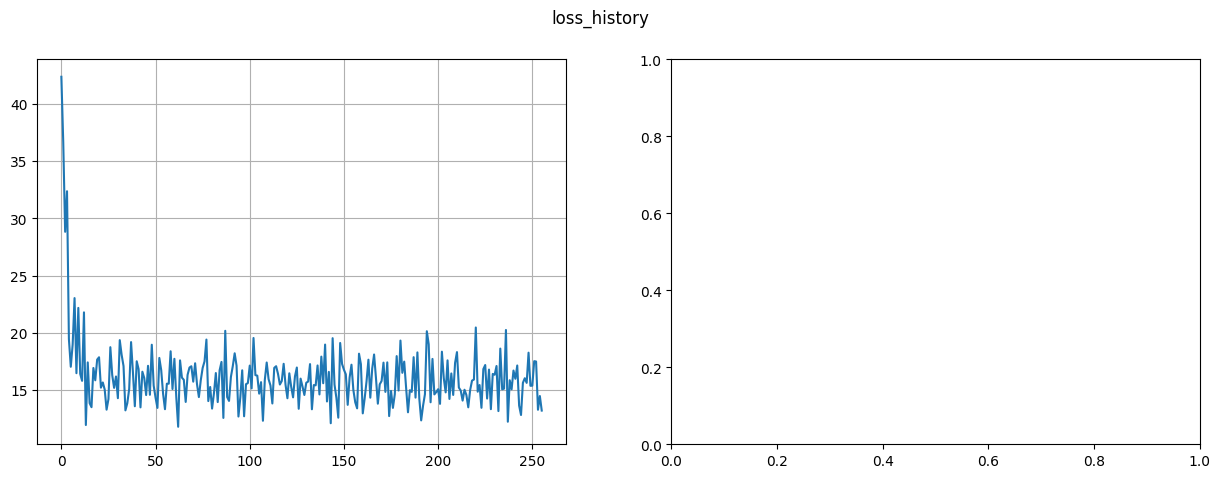

In [271]:
# Виведемо графіки залежності зміни точності та втрат від кроку
def draw_2simple_2d(x1: np.array, y1: np.array, suptitle: str) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(x1, y1)
    axs[0].grid()
    # axs[1].plot(x1, y2)
    fig.suptitle(suptitle)
    # axs[1].grid()


x = np.array([point * 1 for point in range(len(loss_history))])

draw_2simple_2d(x, loss_history, suptitle='loss_history')

- https://github.com/tensorflow/docs